# Wasserstein distances

Consider data $y_{1:n}$ with $y_i\in\mathbb{R}^{n_y}$ and $n\in\mathbb{N}$ the number of i.i.d. replicates. A common distance measure would be e.g. a (weighted) Euclidean distance $\|y_{1:n} - \bar y_{1:n}\|$ on the vectorized data space. However, due to inherent stochasticity, this distance measure suffers from high variability. Thus, as an alternative summary statistics can be used. However, these may lead to a loss of information.
An alternative suggested by [Bernton et al. 2019](https://arxiv.org/pdf/1905.03747) is to operate on the full data by using low-variance Wasserstein distances in terms of empirical distributions of observed and synthetic data. These express distance via an optimal transport problem of minimizing, with respect to an underlying distance metric, the cost of transforming a given (discrete) probability measure into another one.

The Wasserstein distance between discrete distributions $\mu = \{(x_i,a_i)\}$ and $\nu = \{(y_i,b_i)\}$ can be expressed as

$$
W_p(\mu,\nu) = \left(\sum_{i,j}\gamma^*_{ij}M_{ij}\right)^{1/p}
$$

where the optimal transport mapping is given as

$$
\gamma^* = \text{argmin}_{\gamma \in \mathbb{R}^{m\times n}}
\sum_{i,j}\gamma_{ij}M_{ij}
\quad\text{such that}\quad
\gamma 1 = a; \gamma^T 1= b; \gamma\geq 0
$$

where $M\in\mathbb{R}^{m\times n}$ is the pairwise cost matrix defining the cost to move mass from bin $x_i$ to bin $y_j$, e.g. expressed via a distance metric, $M_{ij} = \|x_i - y_j\|_p$, and $a$ and $b$ are histograms weighting samples (e.g. uniform). See e.g. https://en.wikipedia.org/wiki/Wasserstein_metric for details.

As the solution of the optimal transport problem may be computationally challenging for high-dimensional problems, [Nadjahi et al. 2020](https://ieeexplore.ieee.org/document/9054735) suggest to project multi-dimensional distributions to one-dimensional ones via linear projections, and then averaging 1d Wasserstein distances, which can be efficiently calculated by sorting, across various projections via a Monte-Carlo integral.

In this notebook, we illustrate the use of Wasserstein distances in pyABC via a simple problem consisting of 100 samples from a 2-dimensional normal distribution. The problem is taken from the original paper Bernton et al. Besides Wasserstein and Sliced Wasserstein distance, we employ a basic Euclidean distance, as well as the mean over samples, which is here known to be a sufficient summary statistic of the parameter-dependent mean.

In [1]:
# install if not done yet
!pip install pyabc[ot] --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tempfile

import pyabc

pyabc.settings.set_figure_params("pyabc")  # for beautified plots

In [3]:
p_true = {"p0": -0.7, "p1": 0.1}
cov = np.array([[1, 0.5], [0.5, 1]])
n = 100

def model(p):
    mean = np.array([p["p0"], p["p1"]])
    # shape (n, 2)
    y = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
    return {"y": y}

data = model(p_true)
prior = pyabc.Distribution(**{
    par: pyabc.RV("norm", p_true[par], 0.25)
    for par in p_true}
)
prior_bounds = {par: (p_true[par] - 0.7, p_true[par] + 0.7) for par in p_true}

class IdSumstat(pyabc.Sumstat):
    """Identity summary statistic."""
    def __call__(self, data: dict) -> np.ndarray:
        # shape (n, dim)
        return data["y"]
    
class SuffSumstat(pyabc.Sumstat):
    """Sufficient summary statistic."""
    def __call__(self, data: dict) -> np.ndarray:
        # shape (dim,)
        return np.mean(data["y"], axis=0)
    
# population size too small for practice
pop_size = 200
max_eval = int(2e4)

Above, we define the `IdSumstat` summary statistic, which simply exports the model output dictionary to the format expected by the Wasserstein distances, of shape (n_sample, n_y). Further, we define `SuffSumstat`, which calculates the sample mean as a statistic sufficient for the distribution mean.

In [4]:
%%time

# analysis settings of distance and summary statistics
settings = {
    "Euclidean": pyabc.PNormDistance(p=2),
    "2-Wasserstein": pyabc.WassersteinDistance(
        p=2, sumstat=IdSumstat(),
    ),
    "Sliced-2-Wasserstein": pyabc.SlicedWassersteinDistance(
        metric="sqeuclidean", p=2, sumstat=IdSumstat(),
        # number of random projections for Monte-Carlo integration
        n_proj=10,
    ),
    "Sufficient summary": pyabc.PNormDistance(
        p=2, sumstat=SuffSumstat(),
    ),
}

# runs
db_file = tempfile.mkstemp(suffix=".db")[1]
hs = []
for id_, distance in settings.items():
    print(id_)
    abc = pyabc.ABCSMC(model, prior, distance, population_size=pop_size)
    h = abc.new(db="sqlite:///" + db_file, observed_sum_stat=data)
    abc.run(max_total_nr_simulations=max_eval)
    hs.append(h)

ABC.Sampler INFO: Parallelize sampling on 4 processes.


Euclidean


ABC.History INFO: Start <ABCSMC id=1, start_time=2021-10-26 16:27:16>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.96668229e+01.
ABC INFO: Accepted: 200 / 421 = 4.7506e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 1.89629700e+01.
ABC INFO: Accepted: 200 / 754 = 2.6525e-01, ESS: 1.8892e+02.
ABC INFO: t: 2, eps: 1.85163522e+01.
ABC INFO: Accepted: 200 / 1584 = 1.2626e-01, ESS: 1.7913e+02.
ABC INFO: t: 3, eps: 1.81457514e+01.
ABC INFO: Accepted: 200 / 3003 = 6.6600e-02, ESS: 1.8636e+02.
ABC INFO: t: 4, eps: 1.78737832e+01.
ABC INFO: Accepted: 200 / 5141 = 3.8903e-02, ESS: 1.8467e+02.
ABC INFO: t: 5, eps: 1.76179843e+01.
ABC INFO: Accepted: 200 / 9595 = 2.0844e-02, ESS: 1.7950e+02.
ABC INFO: Stop: Total simulations budget.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:17.763659, end_time=2021-10-26 16:27:34>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-10-26 16:27:34>
ABC INFO: Calibration sample t = -1.


2-Wasserstein


ABC INFO: t: 0, eps: 5.44317718e-01.
ABC INFO: Accepted: 200 / 406 = 4.9261e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 4.74031246e-01.
ABC INFO: Accepted: 200 / 467 = 4.2827e-01, ESS: 1.7944e+02.
ABC INFO: t: 2, eps: 4.35432047e-01.
ABC INFO: Accepted: 200 / 821 = 2.4361e-01, ESS: 1.6841e+02.
ABC INFO: t: 3, eps: 4.09366836e-01.
ABC INFO: Accepted: 200 / 1429 = 1.3996e-01, ESS: 1.7716e+02.
ABC INFO: t: 4, eps: 3.91588141e-01.
ABC INFO: Accepted: 200 / 2440 = 8.1967e-02, ESS: 1.6067e+02.
ABC INFO: t: 5, eps: 3.79327759e-01.
ABC INFO: Accepted: 200 / 4273 = 4.6806e-02, ESS: 1.1853e+02.
ABC INFO: t: 6, eps: 3.66494717e-01.
ABC INFO: Accepted: 200 / 7863 = 2.5436e-02, ESS: 1.5275e+02.
ABC INFO: t: 7, eps: 3.57739340e-01.
ABC INFO: Accepted: 200 / 13455 = 1.4864e-02, ESS: 6.2379e+01.
ABC INFO: Stop: Total simulations budget.
ABC.History INFO: Done <ABCSMC id=2, duration=0:00:43.851745, end_time=2021-10-26 16:28:17>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Sta

Sliced-2-Wasserstein


ABC INFO: t: 0, eps: 2.87243802e-01.
ABC INFO: Accepted: 200 / 429 = 4.6620e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 2.33893477e-01.
ABC INFO: Accepted: 200 / 519 = 3.8536e-01, ESS: 1.6790e+02.
ABC INFO: t: 2, eps: 2.03418021e-01.
ABC INFO: Accepted: 200 / 731 = 2.7360e-01, ESS: 1.3050e+02.
ABC INFO: t: 3, eps: 1.81446532e-01.
ABC INFO: Accepted: 200 / 1383 = 1.4461e-01, ESS: 1.5666e+02.
ABC INFO: t: 4, eps: 1.64347010e-01.
ABC INFO: Accepted: 200 / 3221 = 6.2093e-02, ESS: 1.4760e+02.
ABC INFO: t: 5, eps: 1.53222116e-01.
ABC INFO: Accepted: 200 / 6944 = 2.8802e-02, ESS: 1.5430e+02.
ABC INFO: t: 6, eps: 1.44552863e-01.
ABC INFO: Accepted: 200 / 12416 = 1.6108e-02, ESS: 1.4268e+02.
ABC INFO: Stop: Total simulations budget.
ABC.History INFO: Done <ABCSMC id=3, duration=0:00:43.480032, end_time=2021-10-26 16:29:01>
ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2021-10-26 16:29:01>
ABC INFO: Calibration sample t = -1.


Sufficient summary


ABC INFO: t: 0, eps: 3.40015438e-01.
ABC INFO: Accepted: 200 / 387 = 5.1680e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 2.15051170e-01.
ABC INFO: Accepted: 200 / 500 = 4.0000e-01, ESS: 1.8806e+02.
ABC INFO: t: 2, eps: 1.52028561e-01.
ABC INFO: Accepted: 200 / 661 = 3.0257e-01, ESS: 1.6137e+02.
ABC INFO: t: 3, eps: 1.09639426e-01.
ABC INFO: Accepted: 200 / 949 = 2.1075e-01, ESS: 1.8386e+02.
ABC INFO: t: 4, eps: 7.48269913e-02.
ABC INFO: Accepted: 200 / 1471 = 1.3596e-01, ESS: 1.4311e+02.
ABC INFO: t: 5, eps: 4.92227101e-02.
ABC INFO: Accepted: 200 / 2763 = 7.2385e-02, ESS: 1.1454e+02.
ABC INFO: t: 6, eps: 3.74878633e-02.
ABC INFO: Accepted: 200 / 5427 = 3.6853e-02, ESS: 1.1259e+02.
ABC INFO: t: 7, eps: 2.65445020e-02.
ABC INFO: Accepted: 200 / 9210 = 2.1716e-02, ESS: 1.4337e+02.
ABC INFO: Stop: Total simulations budget.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:20.443130, end_time=2021-10-26 16:29:21>


CPU times: user 12.4 s, sys: 1.71 s, total: 14.1 s
Wall time: 2min 5s


The below analysis shows that, given a similar computational budget, the Euclidean distance gives a large variance (note that no scale or informativeness weighting can help here, as all values are and value on the same scale). In comparison, the Wasserstein and Sliced Wasserstein distance give values close to the distribution obtained via the sufficient summary statistic.

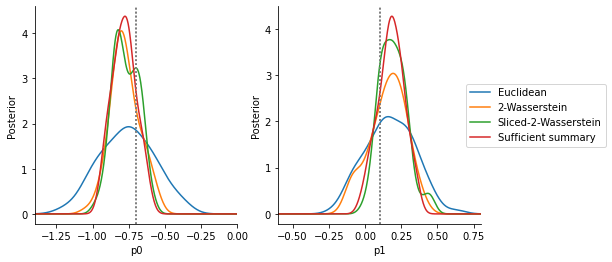

In [5]:
fig, axes = plt.subplots(ncols=len(prior_bounds), figsize=(8, 4))

for i_par, par in enumerate(prior_bounds.keys()):
    for id_, h in zip(settings.keys(), hs):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=par, xname=par,
            xmin=prior_bounds[par][0], xmax=prior_bounds[par][1],
            ax=axes[i_par], label=id_,
            numx=500,
            refval=p_true, refval_color="grey",
        )
axes[-1].legend(bbox_to_anchor=(0.9, 0.5), loc="center left")

Compared to the in this case short model simulation time, the solution of the optimal transport problem constitutes a not unsubstantial computational overhead, as an analysis of overall run-times shows (see below). The Sliced Wasserstein distance is typically more efficient than the Wasserstein distance solving the multi-dimensional transport problem, with accuracy and speed-up depending somewhat on the number of Monte-Carlo projections `n_proj`.

<AxesSubplot:title={'center':'Total walltimes'}, xlabel='Run', ylabel='Time [s]'>

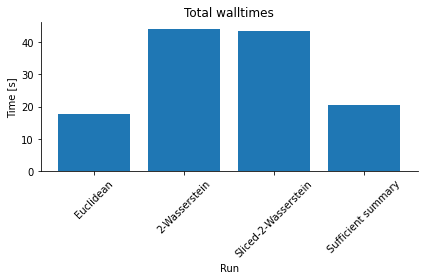

In [6]:
pyabc.visualization.plot_total_walltime(hs, list(settings.keys()), rotation=45)

The Wasserstein distance approach has also been applied to structured, e.g. time-resolved or spatial, data, see e.g. Bernton et al. for further studies.